In [13]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score
)
from sklearn.calibration import calibration_curve
from scipy.special import expit

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
# Load Synthetic Data

gaussian_copula = pd.read_csv('Synthetic_data(Gaussian Copula).csv', index_col=False)
gaussian_copula = gaussian_copula.iloc[:,1:]

# Load Train Data
x_df = pd.read_csv('x_df.csv')
x_df = x_df.iloc[:, 1:]

# Load Label Data
y_df_binarized = np.load('y_df_binarized.npy')

# Combined df
full_df = x_df
full_df['dna'] = y_df_binarized

In [23]:
# Data_processing Module
def datasize_check(data, name):
    '''
    Data Size Checking

    Return : data shape and class distribution
    '''
    print(f'Data shape of {name}: {data.shape}')
    print(f'Class Distribution : {Counter(data["dna"])}\n')

def making_valid_data(data, number):
    '''
    60 validation dataset 

    Return Validation data
    '''
    df_0 = data[data['dna'] == 0].sample(number, random_state=42)
    df_1 = data[data['dna'] == 1].sample(number, random_state=42)

    result = pd.concat([df_0, df_1])

    train = data.drop(result.index)

    return train, result

def prepare_vis_com_data(data, synthetic):


    data = data.copy()
    synthetic = synthetic.copy()
    
    data['source'] = "Real"
    synthetic['source'] = "Synthetic"
    combined = pd.concat([data, synthetic], axis=0)
    
    features = combined.drop(columns=['dna', 'source'])
    labels = combined['source']
    
    return features, labels

def break_imbal(synthetic):
    synthetic_1 = synthetic[synthetic['dna'] == 1]

    return synthetic_1


def filter_class_get_compound_name(model, cpg_path, meta_path, chem_path):

    # Load Data
    cpg = pd.read_csv(cpg_path).iloc[:, 1:]
    cpg_meta = pd.read_csv(meta_path).iloc[:, 1:]
    chem_dat = pd.read_csv(chem_path)

    print(f'cpg0012 Data size: {cpg.shape}')
    print(f'Chemical Meta Data size: {cpg.shape}\n')

    # Predict with model
    y_pred_1 = model.predict(cpg)
    print(f'Predicted Compound Distribution{Counter(y_pred_1)}\n')

    indices_with_1 = [i for i, pred in enumerate(y_pred_1) if pred == 1]

    # Initialize a list to store compound names
    comp_name = []

    # Map predictions to compound names
    for idx in indices_with_1:
        value = cpg_meta.iloc[idx]['Metadata_broad_sample']
        name = chem_dat[chem_dat['BROAD_ID'] == value]['CPD_NAME'].tolist()
        comp_name.extend(name)

    # Remove invalid entries
    comp_name = [v for v in comp_name if v]

    return comp_name

def filter_BRD(comp_name):

    filtered_comp_name = [
        name for name in comp_name
        if isinstance(name, str) and not name.startswith('BRD')
    ]

    print(f'Lenght of Non-BRD Hit Compound: {len(filtered_comp_name)}')

    return filtered_comp_name


# Model Training Module
def data_split(data, target, size):
    '''
    Train test Data Split

    Return:
    train & test data
    '''
    x_df = data.drop(columns=target)
    y_df = data[target]

    X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, stratify=y_df, test_size=size, random_state=42)

    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)

    print(f'Train Target Count: {Counter(y_train)}')
    print(f'Test Target Count: {Counter(y_test)}')

    return X_train, X_test, y_train, y_test

def ML_train(X_train, X_test, y_train, y_test, model_name):

    '''
    Machine Learning for   SVM , Logistic, SGD, LGBM

    Return:

    '''

    if model_name == 'SVM':
        
        # Class weight Setting
        class_weight = {0: 2, 1: 1.7}

        # SVM Parmeter Setting
        param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly']
        }

        # SVM Model Setting
        model = SVC(random_state=42, class_weight=class_weight)


    elif model_name == 'Logistic':
        # Class weight Setting
        class_weight = {0: 1, 1: 1}

        # Logistic Parmeter Setting
        param_grid = {
        'C': [0.1, 1, 10],
        'penalty' : ['l1', 'l2']
        }

        # Logistic Model Setting
        model = LogisticRegression(random_state=42, class_weight=class_weight)

    elif model_name == 'SGD':
        # Class weight Setting
        class_weight = {0: 2, 1: 3}

        # SGD Parmeter Setting
        param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty' : ['l1', 'l2']
        }
        # SGD Model Setting
        model = SGDClassifier(random_state=42, class_weight=class_weight)

    elif model_name == 'LGBM':
        # LightGBM Parameter Setting
        param_grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7]
        }
        # LightGBM Model Setting
        model = LGBMClassifier(random_state=42, scale_pos_weight=3) 

    else:
        print('Check Model Name.')




    # Best Parameter Searching
    result = {}

    # Stratified K-Fold Setting
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(f"Training {model_name}...\n")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring='roc_auc_ovr', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best Parameters & 5 Fold-cross validation
    cv_results = grid_search.cv_results_

    fold_f1_scores = []
    for i in range(5):
        print(f'Fold {i+1} Training ................\n')

    print(f"Best Parameters for {model_name}:")
    print(grid_search.best_params_)

    # Prediction with best estimator
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # AUC ROC Calculation
    if model_name == 'LGBM':
        auc_roc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    else:
        auc_roc = roc_auc_score(y_test, best_model.decision_function(X_test))

    # Assessment score present
    print(f"\nTest Result for {model_name}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Generate classification report as a dictionary
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store result 
    result[model_name] = {
        'f1_score': report['weighted avg']['f1-score'],
        'accuracy': report['accuracy']
    }

    # Final Results Reporting
    print(f"\n{model_name} Test Results:")
    print(f"{model_name} F1-score : {result[model_name]['f1_score']: .4f}, AUC ROC : {auc_roc:.4f}, Accuracy : {result[model_name]['accuracy']:.4f}")

    return best_model, result
 
def val_result(data, model):
    y_pred = model.predict(data.drop(columns='dna'))
    print(classification_report(data['dna'], y_pred))
    result = classification_report(data['dna'], y_pred, output_dict=True)

    report_df = pd.DataFrame(result).transpose()

    model_name = model.__class__.__name__
    report_df.to_excel(f'{model_name}_classification_result.xlsx')
    
    return report_df



# Visualization module

def vis_bar(results, model_names):

    metrics = ['Accuracy', 'Weighted F1-Score']
    data = []

    for result, name in zip(results, model_names):
        accuracy = result.loc['accuracy', 'precision']
        weighted_f1 = result.loc['weighted avg', 'f1-score']
        data.append([name, accuracy, weighted_f1])

    plot_df = pd.DataFrame(data, columns=["Model", "Accuracy", "Weighted F1-Score"])


    ax = plot_df.set_index('Model').plot(kind='bar', figsize=(8, 6))
    plt.title('Comparison of Model Performance')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.legend(title="Metrics")

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def visualize_dim_reduction(data, labels, method='pca', random_state=42, **kwargs):
    
    if method.lower() == 'pca':
        reducer = PCA(n_components=2, **kwargs)
    elif method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=random_state, **kwargs)
    elif method.lower() == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=random_state, **kwargs)
    else:
        raise ValueError('Invalid method. Choose from "pca", "tsne", "umap"')
    

    reduced_data = reducer.fit_transform(data)

    # Visualization
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)

    colors = ['red', 'blue']

    for i, label in enumerate(unique_labels):
        idx = labels == label
        plt.scatter(reduced_data[idx, 0], reduced_data[idx, 1], label=label, alpha=0.3,
                    s=15, c=colors[i])
    plt.title(f'{method.upper()} Visualization')
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_model_performance(y_true, y_pred, y_probs, model_name="Model"):
    # Create figure and axes
    fig, axes = plt.subplots(2, 3, figsize=(20, 15), dpi=300)
    
    # Apply professional journal-style settings
    sns.set_style("white")
    sns.set_theme(style='darkgrid', context='paper')
    plt.rcParams.update({
    "font.family": "serif",  
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 300,       # High-resolution figure
    "savefig.dpi": 300       # Save figures in high resolution
})

    # ✅ 1. Confusion Matrix (Enhanced Style)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0, 0], 
                annot_kws={"size": 14}, linewidths=0.5, linecolor="black")
    axes[0, 0].set_title("Confusion Matrix", fontweight="bold")
    axes[0, 0].set_xlabel("Predicted Label")
    axes[0, 0].set_ylabel("True Label")

    # ✅ 2. ROC Curve (Smooth Curve)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    axes[0, 1].plot(fpr, tpr, color='#ff7f0e', lw=3, label=f'AUC = {roc_auc:.2f}')
    axes[0, 1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
    axes[0, 1].set_title("ROC Curve", fontweight="bold")
    axes[0, 1].set_xlabel("False Positive Rate")
    axes[0, 1].set_ylabel("True Positive Rate")
    axes[0, 1].legend(loc="lower right")

    # ✅ 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    axes[0, 2].plot(recall, precision, color='#1f77b4', lw=3, label="PR Curve")
    axes[0, 2].set_title("Precision-Recall Curve", fontweight="bold")
    axes[0, 2].set_xlabel("Recall")
    axes[0, 2].set_ylabel("Precision")
    axes[0, 2].legend(loc="lower left")

    # ✅ 4. F1-score, Precision, Recall Bar Chart (Edge Enhancement)
    metrics = ["F1-score", "Precision", "Recall"]
    scores_0 = [
        f1_score(y_true, y_pred, pos_label=0),
        precision_score(y_true, y_pred, pos_label=0),
        recall_score(y_true, y_pred, pos_label=0)
    ]
    scores_1 = [
        f1_score(y_true, y_pred, pos_label=1),
        precision_score(y_true, y_pred, pos_label=1),
        recall_score(y_true, y_pred, pos_label=1)
    ]

    x = np.arange(len(metrics))
    width = 0.35
    bars1 = axes[1, 0].bar(x - width/2, scores_0, width, label="Class 0", color="#1f77b4", edgecolor='black', alpha=0.85)
    bars2 = axes[1, 0].bar(x + width/2, scores_1, width, label="Class 1", color="#d62728", edgecolor='black', alpha=0.85)

    # ✅ Annotate values on bars (Improve readability)
    for bar in bars1 + bars2:
        height = bar.get_height()
        axes[1, 0].annotate(f'{height:.2f}', 
                             xy=(bar.get_x() + bar.get_width() / 2, height),
                             xytext=(0, 5), textcoords="offset points", 
                             ha='center', fontsize=12)

    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(metrics)
    axes[1, 0].set_title("Performance Metrics", fontweight="bold")
    axes[1, 0].legend()

    # ✅ 5. Prediction Probability Distribution (Adjust Alpha)
    sns.kdeplot(y_probs[y_true == 0], label="Class 0", ax=axes[1, 1], color='#1f77b4', fill=True, alpha=0.5)
    sns.kdeplot(y_probs[y_true == 1], label="Class 1", ax=axes[1, 1], color='#d62728', fill=True, alpha=0.5)
    axes[1, 1].set_title("Prediction Probability Distribution", fontweight="bold")
    axes[1, 1].set_xlabel("Predicted Probability")
    axes[1, 1].legend()

    # ✅ 6. Calibration Curve (Add Regression Line)
    prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
    axes[1, 2].scatter(prob_pred, prob_true, label="Model Calibration", color="#2ca02c")
    sns.regplot(x=prob_pred, y=prob_true, scatter=False, ax=axes[1, 2], color="#2ca02c", ci=None)
    axes[1, 2].plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1.5, label="Perfect Calibration")
    axes[1, 2].set_title("Calibration Curve", fontweight="bold")
    axes[1, 2].set_xlabel("Predicted Probability")
    axes[1, 2].set_ylabel("True Probability")
    axes[1, 2].legend()

    # ✅ Set overall title
    plt.suptitle(f"{model_name} Performance Overview", fontsize=20, fontweight="bold")
    
    # ✅ Adjust layout for optimal spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(hspace=0.35, wspace=0.3)

    plt.show()

In [5]:
# Data Size Chekcing
datasize_check(gaussian_copula, 'Gaussian_Copula')
datasize_check(full_df, 'Training Data')

Data shape of Gaussian_Copula: (1841, 737)
Class Distribution : Counter({0: 1578, 1: 263})

Data shape of Training Data: (357, 737)
Class Distribution : Counter({0: 306, 1: 51})



In [6]:
# Ready for validation dataset
train, val_df = making_valid_data(full_df, 30)

datasize_check(val_df, 'Validation Data')

Data shape of Validation Data: (60, 737)
Class Distribution : Counter({0: 30, 1: 30})



## Gaussian Copula 

In [7]:
# Combined Data
comb_dat = pd.concat([train, gaussian_copula], axis=0)
datasize_check(comb_dat, 'Combined Data')

Data shape of Combined Data: (2138, 737)
Class Distribution : Counter({0: 1854, 1: 284})



In [8]:
# Data Split
X_train, X_test, y_train, y_test = data_split(comb_dat, 'dna', 0.15)

svm_model, svm_result = ML_train(X_train, X_test, y_train, y_test, 'SVM')

Train Target Count: Counter({0: 1576, 1: 241})
Test Target Count: Counter({0: 278, 1: 43})
Training SVM...

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fold 1 Training ................

Fold 2 Training ................

Fold 3 Training ................

Fold 4 Training ................

Fold 5 Training ................

Best Parameters for SVM:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Test Result for SVM:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       278
           1       0.77      0.63      0.69        43

    accuracy                           0.93       321
   macro avg       0.86      0.80      0.82       321
weighted avg       0.92      0.93      0.92       321


SVM Test Results:
SVM F1-score :  0.9219, AUC ROC : 0.9551, Accuracy : 0.9252


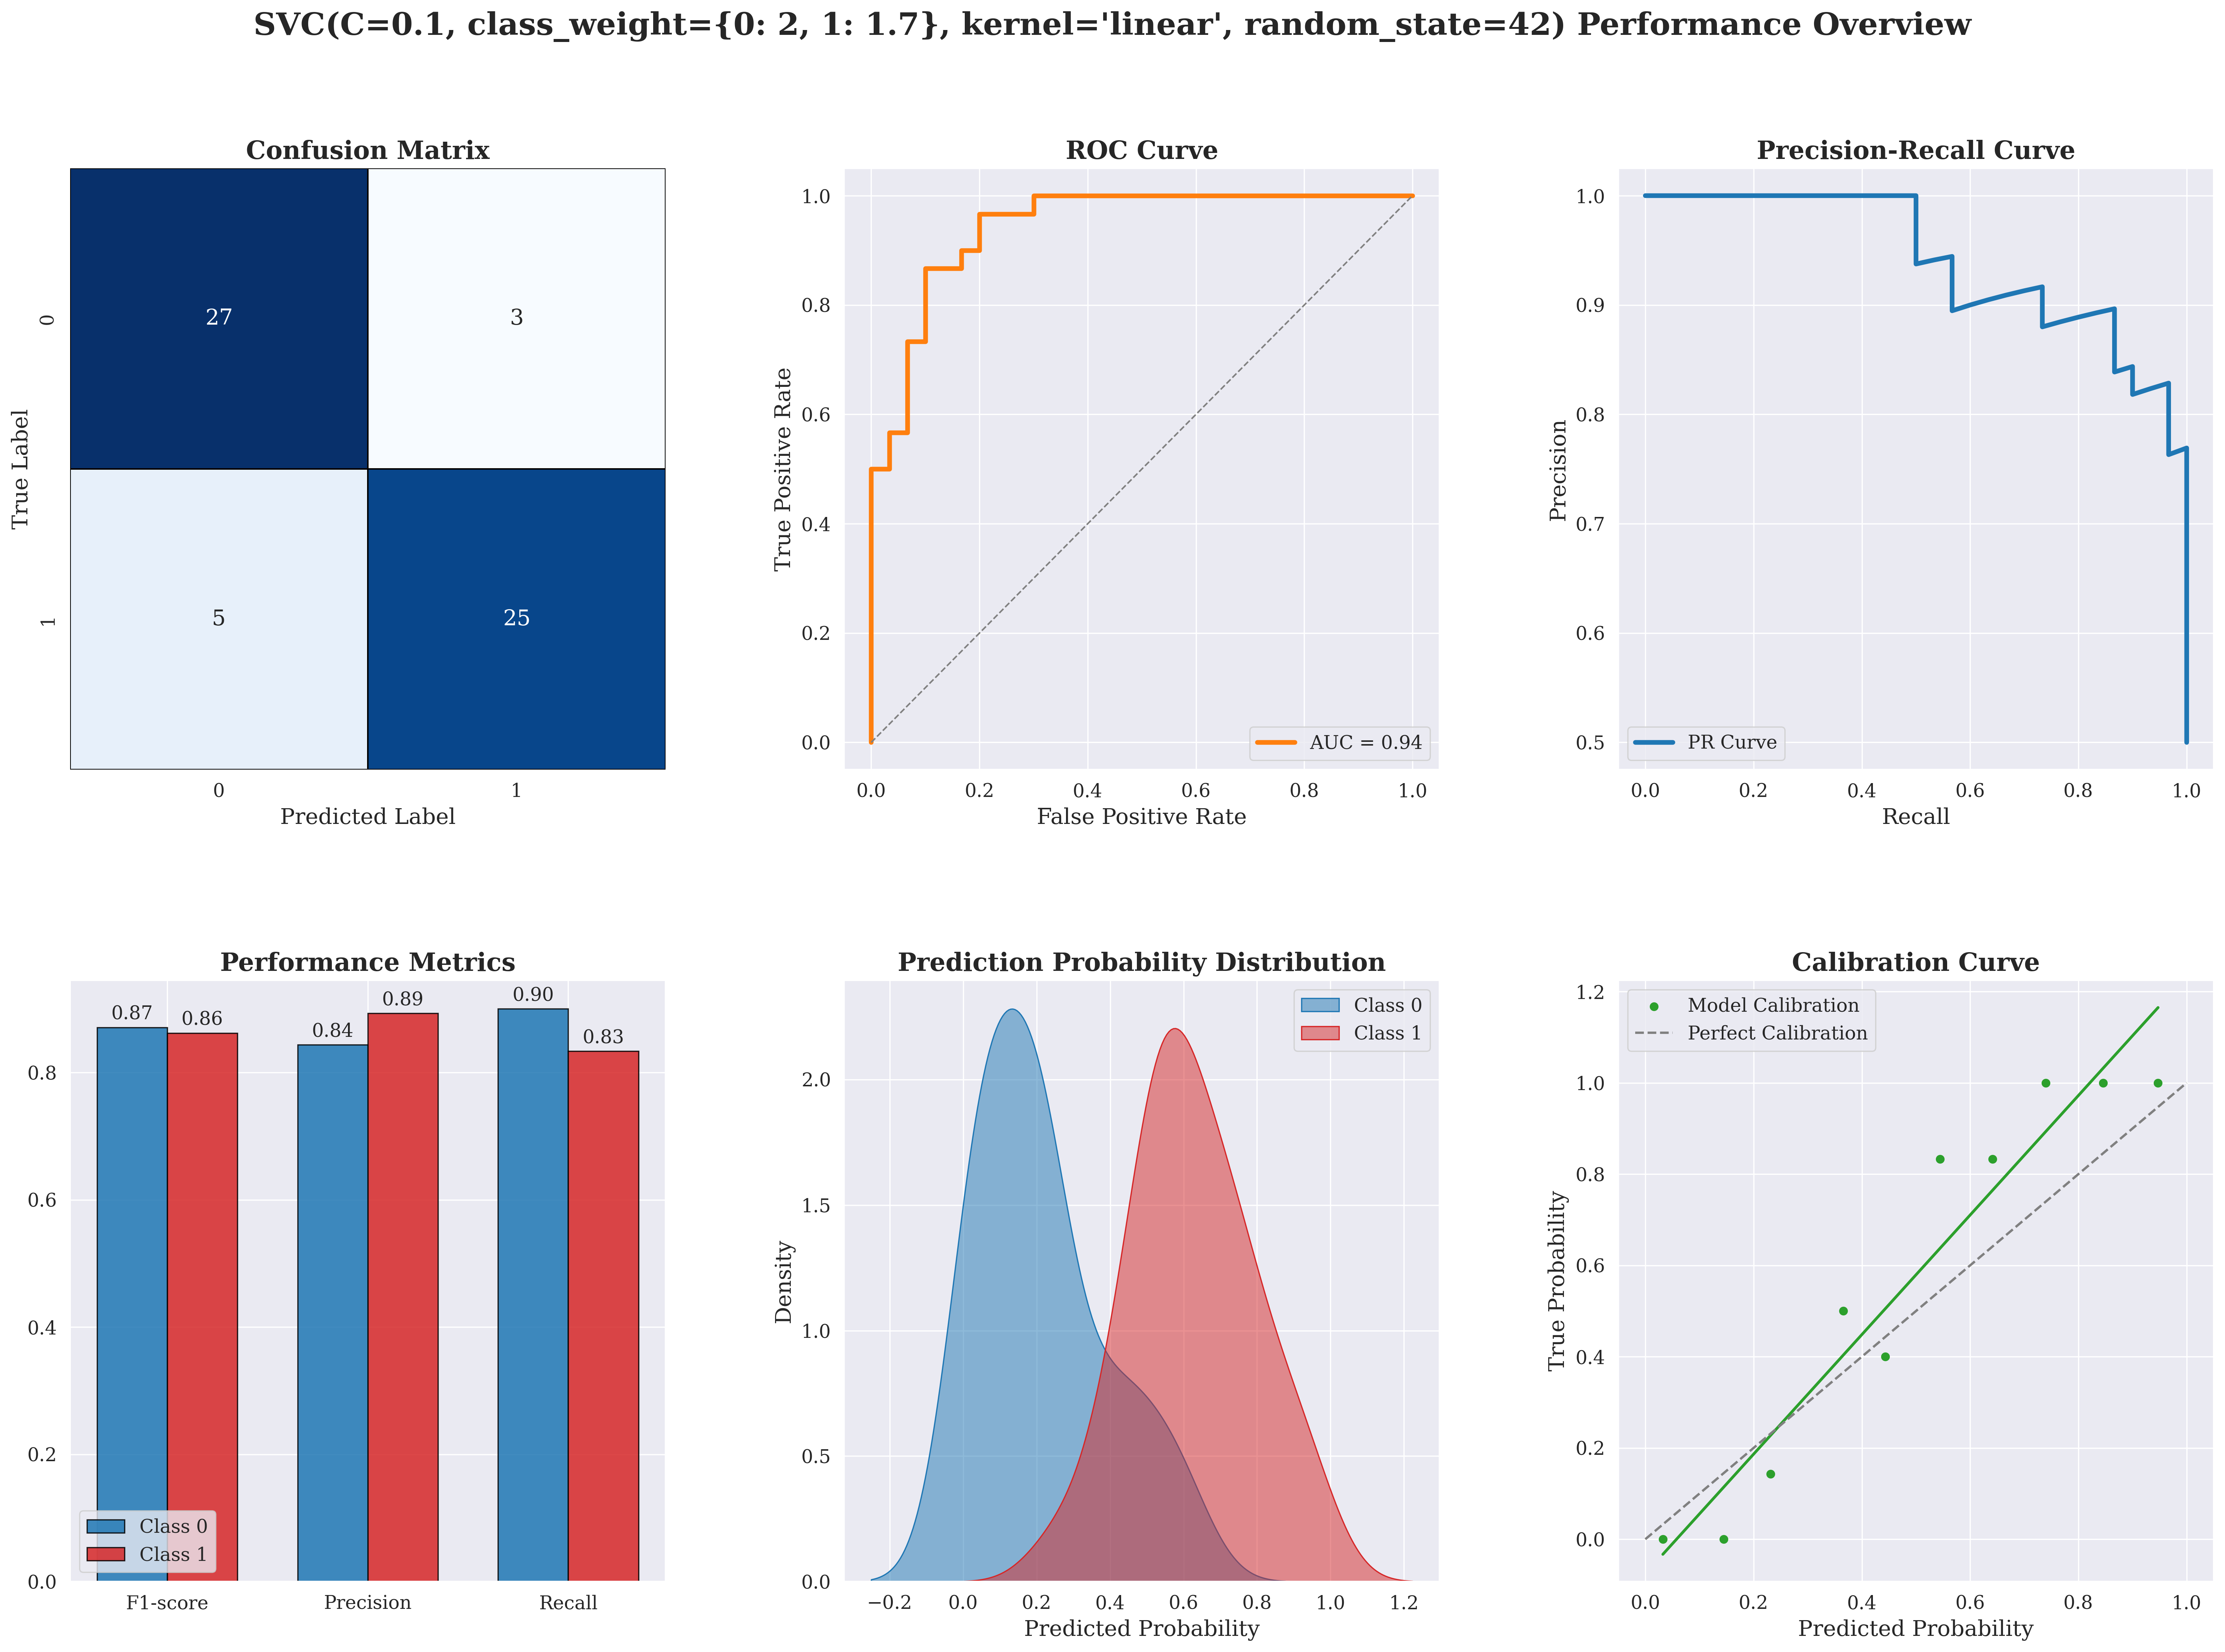

In [24]:
# Performance Visualizaiton

y_pred = svm_model.predict(val_df.drop(columns = 'dna'))
y_scores = svm_model.decision_function(val_df.drop(columns = 'dna'))
y_probs = expit(y_scores)

plot_model_performance(val_df['dna'], y_pred, y_probs, model_name=svm_model)